In [3]:

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:

# Set some parameters
im_width = 128
im_height = 128
border = 5

In [5]:
ids = next(os.walk("/content/drive/MyDrive/Apple_Data_Set/detection/train/images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  670


In [6]:
ids = next(os.walk("/content/drive/MyDrive/Apple_Data_Set/detection/train/masks"))[2] # list of names all images in the given path
print("No. of masks = ", len(ids))

No. of masks =  670


In [7]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [8]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/MyDrive/Apple_Data_Set/detection/train/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/drive/MyDrive/Apple_Data_Set/detection/train/masks/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [9]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Mask')

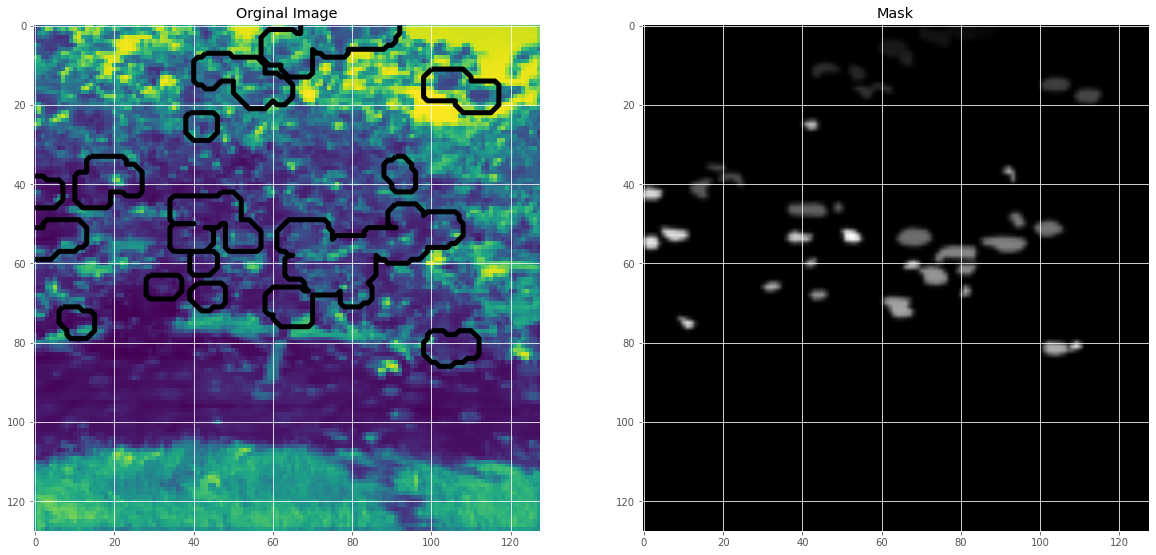

In [49]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0],)
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Orginal Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')


In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [12]:
  def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:

input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [15]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [16]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
19/19 [==============================] - 11s 120ms/step - loss: 0.2545 - accuracy: 0.8846 - val_loss: 0.4360 - val_accuracy: 0.9021

Epoch 00001: val_loss improved from inf to 0.43604, saving model to model-tgs-salt.h5
Epoch 2/50
19/19 [==============================] - 1s 62ms/step - loss: 0.1621 - accuracy: 0.8973 - val_loss: 0.2178 - val_accuracy: 0.9021

Epoch 00002: val_loss improved from 0.43604 to 0.21775, saving model to model-tgs-salt.h5
Epoch 3/50
19/19 [==============================] - 1s 64ms/step - loss: 0.1191 - accuracy: 0.8980 - val_loss: 0.1464 - val_accuracy: 0.9021

Epoch 00003: val_loss improved from 0.21775 to 0.14637, saving model to model-tgs-salt.h5
Epoch 4/50
19/19 [==============================] - 1s 63ms/step - loss: 0.0941 - accuracy: 0.8992 - val_loss: 0.1106 - val_accuracy: 0.9021

Epoch 00004: val_loss improved from 0.14637 to 0.11059, saving model to model-tgs-salt.h5
Epoch 5/50
19/19 [==============================] - 1s 63ms/step - loss: 0

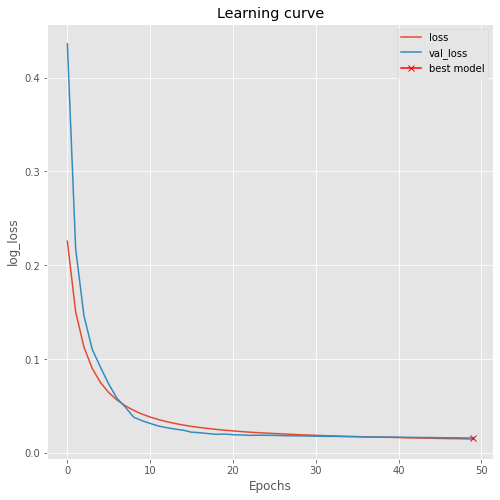

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [18]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [19]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

3/3 [==============================] - 0s 10ms/step - loss: 0.0162 - accuracy: 0.9021


[0.016155587509274483, 0.90214604139328]

In [44]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

3/3 [==============================] - 0s 16ms/step


In [45]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


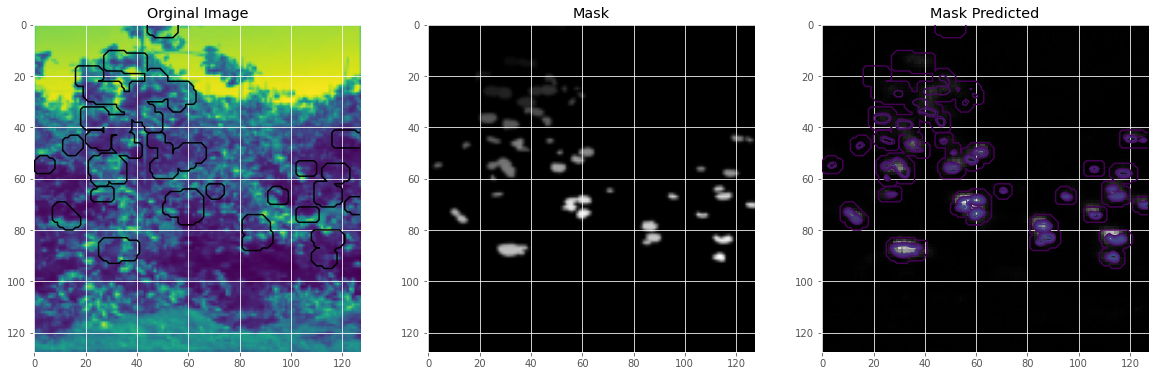

In [68]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Orginal Image')

    ax[1].imshow(y[ix].squeeze(), cmap='gray', interpolation='bilinear')
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), cmap='gray', interpolation='none')
    if has_mask:
        ax[2].contour(y[ix].squeeze(),vmin=0, vmax=1)
    ax[2].set_title('Mask Predicted')
    
  
    # Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t)